# CS 224, Winter 2021
## Problem Set 4

## Due March 14, 2021 @ 11:59pm PST


<div class="alert alert-info">
    <b>Complete with your Information</b><br>
    <i>By Submitting this notebook, I assert that all of the work presented here is my own and performed for the express sole purpose of this offering of this course.</i><br>
        <br>
      <b>(full) Name:</b>  Sakshar Chakravarty  <br>
    <b>Student ID Number:</b> 862253039
</div>

<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: 23.5/24<br>
    Late Days Used on this assignment: 2<br>
    Total Late Days Used: <br>
</div>

## OVERVIEW

In this problem set, we will be modeling the spelling of words.  That is, we will be modeling the sequence of letters that make up English words.

In the realm of natural language modeling, this is not the most exciting part (modeling sequences of words in sentences, for instance, is more related to meaning).  However, this is a simpler, smaller task (there are fewer letters than there are words) and therefore more suitable to a first HMM project.

The models we will end up with are not state-of-the-art.  However, state-of-the-art models are built in much the same way, just with added "fanciness."


## Loops

Implementing HMMs and Markov models naturally leads to loops.  The loops over "time" (t), usually from 1 to T, are unavoidable.  

The loops over states or observations (usually from 1 to K or 1 to L) are easily removed (in favor of numpy expressions that do the same).  You should certainly do this, otherwise your code will be too slow.

The loops over data examples (from 1 to m) are more difficult to remove.  Because T is constant across examples, they can be removed and your code will run much faster.  As an example, if you have a row vector `v` and wish to multiply it by the matrix `A`, you can do this with `v@A`.  If you have a set of `v`s to so multiply, you could run a loop.  *Or*, you could stack these vectors into a tall matrix `V` (one `v` per row) and do `V@A` and get out all of the answers at once.  This is many times faster.

You do *not* need to remove loops over data examples.  However, you will probably be happier (and your code shorter) if you do.  I recommend first implementing a function with a loop (as it is easier to check that you have done it correctly).  Test it on a small bit of data to see that it works.  Then, implement a version without a loop over data examples.  Check that you get the same answer out of both.  

## Data

To get a set of words, with their "natural" frequency of occurance, we will be using the text of Lewis Carroll's "Alice in Wonderland."  

The code below imports all modules you are allowed to use (do not add any others!) and loads in the text.

Each word is considered it's own example (remember, we are not modeling the ordering of words, only the ordering of spelling within words).  All words have been converted to uppercase and extended (with spaces) to be exactly 14 letters long.  This means that there are 27 observation ('A' = 0, 'B' = 1, ..., 'Z' = 25, '_' = 26) and T = 14 for all sequences.

## Code

This implementation has been broken up for you into functions to implement.  No single function is longer than 10-15 lines of code (and many are only 3-4 lines).  

Do **not** adjust the input arguments or the outputs, otherwise it will be very difficult to properly grade.  It is certainly possible to organize HMM learning and estimation differently.  Please do not do so.  You may add helper functions if you wish.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.cm import binary as bwcolormap
from IPython.display import display, clear_output, Markdown

def loadtext(fname):
    nonletter = re.compile('[^a-zA-Z]+')

    words = []
    textstate = 0
    with open(fname,'r') as f:
        for word in re.split(nonletter,f.read()):
            if textstate==0:
                if word == 'START':
                    textstate=1
            elif textstate==1:
                if word == 'WONDERLAND':
                    textstate=2
            elif textstate==2:
                words.append(word.upper())
                if word=='END':
                    textstate=3
    return words

def chartoobs(c):
    return ord(c)-ord('A') if c != ' ' else 26

def obstochar(x):
    return chr(x+ord('A')) if x != 26 else ' '

def wordstoX(words):
    mlen = max([len(s) for s in words])
    return np.array([[chartoobs(l) for l in '{0: <{1}}'.format(w,mlen)] for w in words],dtype=int)

def Xtowords(X):
    return [''.join([obstochar(v) for v in x]).rstrip() for x in X]


X = wordstoX(loadtext('aliceinwonderland.txt'))

### Alternative Data

The Alice-in-Wonderland dataset (loaded as `X`, above) has 27,341 examples of sequences, each 14 "timesteps" long.  This might be too large for practical debugging.

The code below generates a smaller dataset (`weatherX`) using the weather-umbrella example from class.  **It isn't used in the problem set**, but you might find it helpful in debugging.

In [2]:
def hmmsample(pi,A,B,T):
    K = A.shape[0]
    nobs = B.shape[1]
    def sampnext(z):
        newz = np.random.choice(K,1,p=A[z,:])[0]
        newx = np.random.choice(nobs,1,p=B[newz,:])[0]
        return (newz,newx)

    def sampinit():
        newz = np.random.choice(K,1,p=pi)[0]
        newx = np.random.choice(nobs,1,p=B[newz,:])[0]
        return (newz,newx)

    z = np.zeros(T,dtype=int)
    x = np.zeros(T,dtype=int)
    z[0],x[0] = sampinit()
    for t in range(1,T):
        z[t],x[t] = sampnext(z[t-1])
    
    return z,x

weatherpi = np.array([0.6,0.3,0.1]) #states are in the order sunny, cloudy, raining
weatherA = np.array([[0.5,0.4,0.1],[0.4,0.3,0.3],[0.2,0.5,0.3]])
weatherB = np.array([[0.1,0.9],[0.5,0.5],[0.8,0.2]]) # obs are in the order umbrella, no-umbrella
weatherm = 20
weatherT = 10

weathersamps = [hmmsample(weatherpi,weatherA,weatherB,weatherT) for i in range(weatherm)]
weatherzx = list(zip(*weathersamps))

weatherZ = np.array(weatherzx[0])
weatherX = np.array(weatherzx[1]) 

## Question 1
### Markov Model

First we will build a Markov model (not an HMM) over the letter sequences

### Question 1a
### 4 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 3/3<br>
</div>

### Markov Chain Sufficient Statistics

Implement the following function to compute the sufficient statistics for the Markov chain.

In [3]:
# X has shape (m,T)
# K is the number of states
# returns the pair (N1,N)
# where N1 has shape (K,)
#   and N has shape (K,K)
def markovsuffstats(X,K):
    ## Your code here
    N1 = np.zeros((K,))
    for i in range(X.shape[0]):
        N1[X[i][0]] += 1
    N = np.zeros((K,K))
    for i in range(X.shape[0]):
        for j in range(1,X.shape[1]):
            N[X[i][j-1]][X[i][j]] += 1
    return (N1, N)

### Question 1b
### 4 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/2<br>
</div>

### Markov Chain MLE

Implement the function below that takes the sufficient statistics and returns the maximum likelihood parameters.

In [4]:
# N1 has shape (K,)
# N has shape (K,K)
# returns the pair (pi,A)
# where pi has shape (K,)
#   and A has shape (K,K)
def markovmle(N1,N):
    ## Your code here
    pi = N1/N1.sum()
    A = np.zeros(N.shape)
    for i in range(N.shape[0]):
        A[i] = N[i]/N[i].sum()
    return (pi, A)

### Question 1c
### 4 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/2<br>
</div>

### Markov Chain Words

Run the following code to sample from a learned model

In [5]:
def markovsample(pi,A,T,rseed=8491920):
    np.random.seed(rseed) ## you may remove this for your own testing, but please place it back and 
            ## run the cell block with this particular random number seed to aid in grading
    K = A.shape[0]
    x = np.zeros(T,dtype=int)
    x[0] = np.random.choice(K,1,p=pi)[0]
    for t in range(1,T):
        x[t] = np.random.choice(K,1,p=A[x[t-1],:])[0]
    return x
    
MCpi,MCA = markovmle(*markovsuffstats(X,27))

In [6]:
print(Xtowords([markovsample(MCpi,MCA,14,i) for i in range(10)]))

['OUSTHER', 'ISALEDNGOTHIF', 'LARORIF', 'OULK', 'WI', 'D', 'UN', 'ATIS', 'T', 'ANKEELIGAND']


## Question 2
### Hidden Markov Model

Now we will model the letter sequences as observations from a hidden Markov model.

### Preliminary Extra Material

Eventually, we will also want to measure the total log-likelihood of a dataset (to monitor the progress of the EM algorithm).  We didn't cover this in class, so here is how to calculate the log-likelihood of the observations:

For a single example, $P(x_{1:T})$ can be rewritten as $P(x_1)P(x_2\mid x_1)P(x_3\mid x_{1:2})P(x_4\mid x_{1:3} \dots P(x_T\mid x_{1:T-1})$.  Each of these terms are just the normalizing constants used in the forward pass (calculating $\alpha$s) on the same data sequence.  Multiplying them together would result in numeric underflow.  However, we want the **log**-likelihood, so adding their logs is fine.

Thus, the log-likelihood of a data sequence is the sum of the logs of the normalizing constants used during the forward pass on the same data sequence.  The log-likelihood of a dataset is the sum of the log-likelihoods across all sequences in the dataset.

### Question 2a
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 5/5<br>
    backward multiplies by 10 for no reason<br>
</div>

### forward-backward algorithm

Implement the forward and backward passes as below.  These functions take in an entire dataset and return the $\alpha$s and $\beta$s for all times for all examples in the dataset.  You may implement them by looping over each example.  However, I recommend eventually converting this to doing all example sequences in parallel.

Calculating $\psi$ first makes things simpler and more modular, so the functions below do not directly depend on B, but depend on B through $\psi$ (which is calculated in its own function)

In [37]:
# X: (m,T) {of integers from 0 to L-1}
# B: (K,L)
# returns psi of shape (m,T,K)
def getpsi(X,B):
    # provided for you:
    return B.T[X,:]
    # as an example, the above is far better than
    #
    # (m,T) = X.shape
    # (K,L) = B.shape
    # ret = np.zeros(m,T,K)
    # for i in range(m):
    #     for t in range(T):
    #         ret[i,t,:] = B[X[i,t],:]
    # return ret
    #
    # let numpy work for you!

# pi: (K,)
# A: (K,K)
# psi: (m,T,K)
# returns alpha, llh
#   alpha: (m,T,K)
#   llh: scalar
def forward(pi,A,psi):
    # Your code here
    mod_psi = np.swapaxes(psi, 0, 1)
    alpha = np.zeros(mod_psi.shape)
    prod = pi*mod_psi[0]
    prod_sum = prod.sum(axis=1).reshape((mod_psi.shape[1], 1))
    llh = np.log(prod_sum).sum()
    alpha[0] = prod/prod_sum
    for t in range(1, mod_psi.shape[0]):
        prod = mod_psi[t]*(alpha[t-1]@A)
        prod_sum = prod.sum(axis=1).reshape((mod_psi.shape[1], 1))
        llh += np.log(prod_sum).sum()
        alpha[t] = prod/prod_sum
    alpha = np.swapaxes(alpha, 0, 1)
    return alpha, llh
# A: K,K
# psi: m,T,K
# ret: m,T,K
def backward(A,psi):
    # Your code here
    mod_psi = np.swapaxes(psi, 0, 1)
    beta = np.ones(mod_psi.shape)
    for t in range(mod_psi.shape[0]-2, -1, -1):
        prod = (mod_psi[t+1]*beta[t+1])@A.T
        beta[t] = prod #10*prod
    beta = np.swapaxes(beta, 0, 1)
    return beta

### Question 2b
### 2 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/2<br>
</div>

### gamma and xi

Implement the following functions to calculate gamma and xi

In [8]:
# A: (K,K)
# psi: (m,T,K)
# alpha: (m,T,K)
# beta: (m,T,K)
# ret: (m,T,K,K)
def getxi(A,psi,alpha,beta):
    # Your code here
    mod_alpha = np.moveaxis(alpha, 0, -1)
    mod_beta = np.swapaxes(beta, 0, 1)
    mod_psi = np.swapaxes(psi, 0, 1)
    xi = np.zeros((alpha.shape[1]-1, alpha.shape[2], alpha.shape[0], alpha.shape[2]))
    for t in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            prod = mod_alpha[t][j].reshape((mod_alpha.shape[-1],1))*A[j].reshape((1,A.shape[-1]))*mod_psi[t+1]*mod_beta[t+1]
            xi[t][j] = prod
    xi = np.swapaxes(np.swapaxes(xi, 1, 2), 0, 1)
    xi_sum = xi.sum(axis=(-2,-1)).reshape((xi.shape[0],xi.shape[1],1,1))
    return xi/xi_sum
# alpha: (m,T,K)
# beta: (m,T,K)
# ret: (m,T,K)
def getgamma(alpha,beta):
    # Your code here
    prod = alpha*beta
    gamma = prod/prod.sum(axis=2).reshape((prod.shape[0], prod.shape[1], 1)) 
    return gamma

### Question 2c
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 5/5<br>
</div>

### EM

Implement the E and M steps for EM with the following functions

Recall that the log-likelihood of the data (calculated the displayed each iteration of EM) should improve every iteration.

In [9]:
# X: (m,T) {of values from 0 to L-1)}
# pi: (K,)
# A: (K,K)
# B: (K,L)
# ret: N1,N,NX
#  N1: (K,)
#  N: (K,K)
#  NX: (K,L)
def estep(X,pi,A,B):
    # Your code here
    psi = getpsi(X, B)
    alpha, _ = forward(pi, A, psi)
    beta = backward(A, psi)
    xi = getxi(A, psi, alpha, beta)
    gamma = getgamma(alpha, beta)
    N1 = gamma[:,0,:].sum(axis=0)
    N = np.zeros(A.shape)
    for j in range(A.shape[0]):
        N[j] = xi[:,:,j,:].sum(axis=(0,1))
    NX = np.zeros(B.T.shape)
    for i in range(X.shape[0]):
        for t in range(X.shape[1]):
            NX[X[i][t]] += gamma[i][t]
    return N1, N, NX.T
# N1: (K,)
# N: (K,K)
# NX: (K,L)
# return (pi,A,B)
#   pi: (K,)
#    A: (K,K)
#    B: (K,L)
def mstep(N1,N,NX):
    # Your code here
    pi = N1/N1.sum()
    A = N/N.sum(axis=1).reshape((N.shape[0],1))
    B = NX/NX.sum(axis=1).reshape((NX.shape[0],1))
    return (pi, A, B)

In [10]:
# X: (m,T)
# pi: (K,)
# A: (K,K)
# B: (K,L)
# returns learned pi,A,B,llhseq
# (starting from input pi,A,B)
# where pi,A,B are learned parameters and llhseq
# is the llh over EM iterations
def em(X,pi,A,B):
    # provided
    i = 0
    oldllh = -np.inf
    llhseq = []
    while True:
        pi,A,B = mstep(*estep(X,pi,A,B))
        llh = forward(pi,A,getpsi(X,B))[1]
        relllhimp = (llh-oldllh)/np.abs(llh)
        llhseq.append(llh)
        clear_output(wait=True)
        display('itt #{0:d}, llh={1:.6f}, rel-llh-imp={2:.6f}'.format(i,llh,relllhimp))
        if relllhimp < 1e-4: break
        oldllh = llh
        i += 1
    return pi,A,B,llhseq

## Question 3
### Putting it together

#### Starting parameter values

Often starting parameter values for $\pi, A, B$ are chosen at random.  We need to make sure that they sum correctly (for instance, that each row of $A$ sums to 1).  The easiest way to do this is to pick random values for the sufficient statistics, and then plug those into the M-step to get random parameters that obey the constraints.

There are a great many things about the spelling of English words we could use to give "hints" to the HMM about how to organize its hidden states.  However, the main purpose of this assignment is to have the method learn these itself.

Instead, we will just use one fact about the special "space" letter that we used to pad all words to the same length.  We know that this observation always comes at the end.  That is, after it is produced, only "spaces" should be produced there after.  This means that we don't need to model any fancy states associated with the space observation.  So, we can tie the space observation to a single state and that state only by initially seeding the B matrix such that the "space" observation can only be generated from one state (say the last state) and that (last) state can only generate the "space" observation.  This way, the HMM won't try to use multiple hidden states to model the simple "end of word" sequence of spaces.


### To Do:

Run the following code to learn HMM models (with various numbers of hidden states)

In [12]:
# K and L are the number of hidden states and the number of observations, respectively
# lastspecial is a flag to indicate whether the last observation should be tied to the last state (see description above)
# returns pi,A,B
def startingparams(K,L,lastspecial=False):
    pseudoNX = np.random.rand(K,L)
    if lastspecial and K>1:
        pseudoNX[:-1,-1] = 0
        pseudoNX[-1,:-1] = 0
    return mstep(np.random.rand(K),np.random.rand(K,K),pseudoNX)

# returns pi,A,B,llhseq
def learnhmm(X,K,L,lastspecial=False):
    return em(X,*startingparams(K,L,lastspecial))

In [13]:
# some code to visualize the resulting parameter matrices
# (plots transpose of pi to make visual fit better)
def plotparams(pi,A,B):
    def plotmat(ax,M):
        ax.matshow(M,cmap=bwcolormap)
        ax.set_xticks([])
        ax.set_yticks([])
    K,L = B.shape
    fig,axs = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,K,L]})
    plotmat(axs[0],pi[:,None])
    plotmat(axs[1],A)
    plotmat(axs[2],B)
    axs[2].set_xticks(list(range(L)))
    axs[2].set_xticklabels([obstochar(x) for x in range(L)])

def runexample(X,K,L,lastspecial=False):
    np.random.seed(158712) # feel free to remove to get randomness on your test
                # but please run your results below with this random number seed
                # (used only for the startingparams) so that grading is simpler
    pi,A,B,llhseq = learnhmm(X,K,L,lastspecial)
    if len(llhseq)>2:
        fig,ax = plt.subplots(1,1,figsize=(2,1))
        plt.plot(llhseq)
        plt.show()
    plotparams(pi,A,B)
    display(Markdown('## {0} hidden states'.format(K)))
    plt.show()
    print("example outputs:")
    print(','.join(Xtowords([hmmsample(pi,A,B,14)[1] for i in range(10)])))

'itt #52, llh=-128.715860, rel-llh-imp=0.000099'

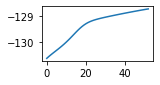

## 3 hidden states

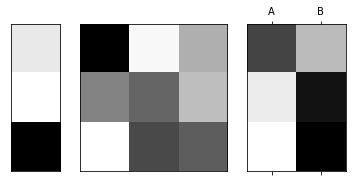

example outputs:
ABABABAAAAABBB,BBAABBAAAABAAA,BBBAABBAAAABBB,BBABBBBAAABABA,ABBBBBABBABBBB,BBBBBBBBAABBAA,BAABBBBBABBABB,BBBBABBBBABBBB,BBAABBBABABABA,BBBBBAABBBBBAB


In [23]:
runexample(weatherX,3,2) # perhaps a good check to run for your code -- not part of the assignment

'itt #1, llh=-538160.285594, rel-llh-imp=0.000000'

## 1 hidden states

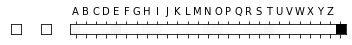

example outputs:
   AN      H G, R   AET    L,BTEEP     EAS,DI  AIA      I,   RI  F     T,S       O A T,     R      H,   M  SIG  HO,   T        E,  H   TD L
CPU times: user 2.35 s, sys: 21.3 ms, total: 2.37 s
Wall time: 2.35 s


In [24]:
%%time
runexample(X,1,27)

'itt #1, llh=-371696.578799, rel-llh-imp=0.000000'

## 2 hidden states

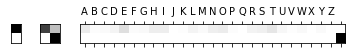

example outputs:
FCA,DEFL,ABNOETOA,I,SBE,O,RHHTRTPTI,C,YP,D
CPU times: user 2.37 s, sys: 35.5 ms, total: 2.4 s
Wall time: 2.38 s


In [25]:
%%time
runexample(X,2,27,True)

'itt #13, llh=-355428.164752, rel-llh-imp=0.000089'

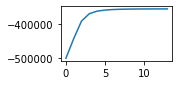

## 3 hidden states

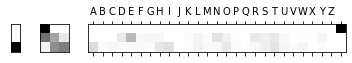

example outputs:
CSNOHKD,AADNO,AHTAL,WOW,HENTTGF,IPEAAIY,NL,IRE,HIUEO,SE
CPU times: user 14.4 s, sys: 294 ms, total: 14.7 s
Wall time: 14.6 s


In [26]:
%%time
runexample(X,3,27,False)

'itt #9, llh=-371630.569178, rel-llh-imp=0.000099'

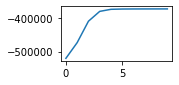

## 5 hidden states

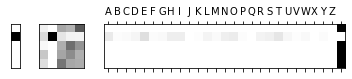

example outputs:
M           Y,EI,C,E,AP,T,OT,WNH,EMLEDLROETCHIO,P
CPU times: user 11.4 s, sys: 525 ms, total: 12 s
Wall time: 11.9 s


In [27]:
%%time
runexample(X,5,27,False)

'itt #71, llh=-334776.821462, rel-llh-imp=0.000077'

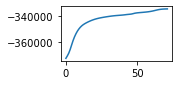

## 5 hidden states

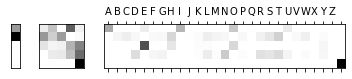

example outputs:
PE,HLO,DUTNHFN,AWU,CHQA,T,SO,WE,HPE,SAN
CPU times: user 1min 18s, sys: 3.21 s, total: 1min 21s
Wall time: 1min 21s


In [29]:
%%time
runexample(X,5,27,True)

'itt #48, llh=-297405.739173, rel-llh-imp=0.000098'

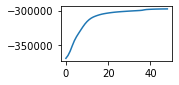

## 15 hidden states

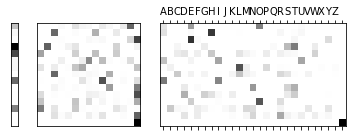

example outputs:
MFALD,LORERE,SHF,MOBOBE,TOILG,SHF,NEAXTK,BOR,BICERE,MEALD
CPU times: user 1min 33s, sys: 13.8 s, total: 1min 46s
Wall time: 1min 46s


In [30]:
%%time
# This one might take a while (it took my code 5 minutes to finish on hub.cs.ucr.edu)
runexample(X,15,27,True)

'itt #84, llh=-274960.283827, rel-llh-imp=0.000093'

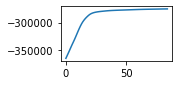

## 30 hidden states

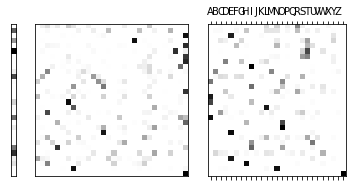

example outputs:
OF,SHE,THATTE,T,RALEN,THEW,SHED,THER,GO,THE
CPU times: user 6min 31s, sys: 1min 26s, total: 7min 58s
Wall time: 7min 57s


In [31]:
%%time
# This one might take a while (it took my code 5 minutes to finish on hub.cs.ucr.edu)
runexample(X,30,27,True)

## What did it learn?

Each of the examples above train a (slightly) more sophisticated model of English spellings.

For each, explain what property or properties it has learned (particularly relative to the previous examples):

### Question 3a-e
### 5 points (scored all here)
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 4.5/5<br>
    Could deduce more than that.  For instance, in 15 states, state 1 is for vowels only
</div>

### Question 3a
### 1 point

What did the model with 1 hidden state learn?

### Your answer here
It is effectively a simple Markov chain. Pi and A both are scalars with value 1. As there is only one state, always the sequence starts and transitions into the same state. B is a vector of normalized frequency of the letters found in the words. It also failed to learn that there is no space inside of a word.

### Question 3b
### 1 point

What did the model with 2 hidden states learn?

### Your answer here
From pi, it can be said that the starting state is always 1 and never 0. From A, it is evident that from state 0, most of the times transitions to state 1 and from state 1, almost always moves to state 1. From B, it is seen that in state 1, space character is never emitted.

This model could learn that space doesn't come inside a word.

### Question 3c
### 1 point

What did the model with 3 hidden states learn?

### Your answer here
From pi, it can be seen that the starting state is either 0 or 1, but never 2. From A, it is found that from state 0, the model transitions to either state 1 or 2, from state 1, its probability of transitioning gradually increases from state 0 to 2, from state 2, the trend is opposite of the previous one. From B, it can be said that all the characters are emitted at each states with some variation in the probability, however, space is never emitted at state 0.

This model started to form more believable Englishy words than the previos two. So, it has a better understanding of the letter sequences in English Language.

### Question 3d
### 1 point

What did the model with 5 hidden states learn?

What was the difference between setting the B matrix specifically to tie the last state to "space" (second version) and not doing so (first version)?

### Your answer here
In the first one, it did not tie the last state to "space" and failed to learn that space doesn't come inside of a word. Pi says that the model never starts at state 1 and A says that all transitions are allowed except from state 1 to itself. B shows that space is only emitted at state 1.

In the second one, it specifically learned that space doesn't come inside of a word. A matrix shows that it has learned that there will never be a transition from the state associated with space to itself. B expresses that state 4 never emits a space.

The main difference was that the learning of the position of space in words. That is why the latter generated better sequence of letters with no space inside of them.

### Question 3e
### 1 point

What did the model with 15 hidden states learn?

### Your answer here
From Pi, it can be said that 4 is never the starting state. From A it is evident that the state 14 (last state) never transitions to itself. B shows that space is never emitted at the last state. It also learned that space is a separator between words. This model tried to generate longer words than any of the previous models. This may indicate that with more states, the model's learning gets more focused towards the formation of longer sequence of letters.

## Final note: 
If you have time, you might want to try to many more hidden states (around 30-50 or so it starts to produce much more "English-y" "words")